<a href="https://colab.research.google.com/github/pepes97/relation-extraction/blob/luca-develop/Relation_Extraction_Binary_Pretrained_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [3]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Librerie

In [44]:
import re
import torch
import random
import numpy as np
from torch import nn
import torch.optim as optim
from itertools import count
from tabulate import tabulate
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score, f1_score, accuracy_score
from torch.nn import Module, Embedding, Dropout, Linear,LSTM
from transformers import BertTokenizer, BertModel, BertTokenizerFast
import nltk
nltk.download('punkt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1234
random.seed(SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data

## Data Semeval

In [45]:
dataset = load_dataset('sem_eval_2010_task_8')

  0%|          | 0/2 [00:00<?, ?it/s]

## Lista delle entità

In [46]:
def lista_tutte_entità_nel_dataset(data, lista_entita):
  relation_dict = {i: label for i, label in enumerate(data.features['relation'].names)}
  for s, r in zip(data['sentence'], data['relation']):
    if relation_dict[r] != "Other":
      tipo1, tipo2 = relation_dict[r].split("(")[0].split("-")
      lista_entita.append(tipo1)
      lista_entita.append(tipo2)
  return list(set(lista_entita))     

### Creazione dati

In [47]:
def create_data(new_data, data, count_yes, lista_entities, max_len=1864):
  relation_dict = {i: label for i, label in enumerate(data.features['relation'].names)}
  for s, r in zip(data['sentence'], data['relation']):
    soup = BeautifulSoup(s, 'html.parser')
    entita = {}
    for tag in soup.find_all(['e1', 'e2']):
        entita[tag.name] = tag.string
        tag.replace_with(entita[tag.name])
    nuova_frase = str(soup) 
    entities = ['O']*len(nuova_frase.split())
    if relation_dict[r]== "Other":
        relation = []
        tipo1, tipo2 = random.sample(lista_entities, 2)
        tipo_entita = {"e1": tipo1, "e2": tipo2}

        for e in entita.keys():
          for i, elem in enumerate(entita[e].split()):
            index_char = nuova_frase.index(elem)
            index_token = nuova_frase[:index_char].count(" ")
            if i == 0:
              entities[index_token] = "B-"+tipo_entita[e]
            else:
              entities[index_token] = "I-"+tipo_entita[e]

        item = {"sentence": nuova_frase, 
          "features": nltk.word_tokenize(nuova_frase),
          "entities": entities,
          "relations": relation}
        new_data.append(item)
    else:
      if count_yes < max_len:
        tipo_soggetto, tipo_oggetto = relation_dict[r].split("(")[0].split("-")
        soggetto = relation_dict[r].split('(')[1].split(',')[0]
        oggetto = relation_dict[r].split('(')[1].split(',')[1].split(")")[0]
        tipo_entita = {soggetto: tipo_soggetto, oggetto: tipo_oggetto}
      
        for e in entita.keys():
          for i, elem in enumerate(entita[e].split()):
            index_char = nuova_frase.index(elem)
            index_token = nuova_frase[:index_char].count(" ")
            if i == 0:
              entities[index_token] = "B-"+tipo_entita[e]
            else:
              entities[index_token] = "I-"+tipo_entita[e]
        relation = [(entita[soggetto], entita[oggetto], relation_dict[r])]
        count_yes+=1
        item = {"sentence": nuova_frase, 
          "features": nuova_frase.split(),
          "entities": entities,
          "relations": relation}
        new_data.append(item)
  return new_data, count_yes

#### Generazione train,valid, test

In [48]:
def generate_train_valid_test(data):
  count_yes = 0
  new_data = []
  lista_entita = []
  train = data['train']
  test = data['test']
  lista_entita = lista_tutte_entità_nel_dataset(train, lista_entita)
  lista_entita = lista_tutte_entità_nel_dataset(test, lista_entita)
  new_data, count_yes = create_data(new_data, train, count_yes, lista_entita)
  new_data, count_yes = create_data(new_data, test, count_yes, lista_entita)
  return new_data

In [49]:
data = generate_train_valid_test(dataset)

# Divisione Train, Valid, Test

In [10]:
# Calcola il numero di istanze per ogni etichetta
label_counts = {}

for item in data:
  relation = item["relations"]
  if len(relation) == 0:
    if "no" in label_counts.keys():
      label_counts["no"] += 1
    else:
        label_counts["no"] = 1
  else:
    if "yes" in label_counts.keys():
      label_counts["yes"] += 1
    else:
        label_counts["yes"] = 1

# Definiamo la proporzione di dati per ogni set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Mescoliamo i dati in modo casuale
random.shuffle(data)

# Calcola il numero di istanze per ciascuna divisione
total_instances = len(data)
train_size = int(train_ratio * total_instances)
test_size = int(test_ratio * total_instances)
dev_size = total_instances - train_size - test_size

# Calcola il numero di istanze per ogni etichetta nella divisione train
train_label_counts = {label: int(count * train_ratio) for label, count in label_counts.items()}

# Inizializza le divisioni train, test e dev
train_set = []
test_set = []
val_set = []

# Dividi il dataset in base alle etichette e alle quantità calcolate
for item in data:
    relation = item["relations"]
    if len(relation) == 0:
      label = "no"
    else:
      label = "yes"

    if train_label_counts[label] > 0:
        train_set.append(item)
        train_label_counts[label] -= 1
    elif test_size > 0:
        test_set.append(item)
        test_size -= 1
    else:
        val_set.append(item)
        dev_size -= 1

# Verifichiamo le lunghezze dei set per assicurarci che siano corrette
print(len(train_set), len(val_set), len(test_set))

2608 561 559


# Statistiche Dati

## Labels

In [11]:
def count_labels(data):
  relations = []
  for d in data:
    r = d["relations"]
    if len(r)==0:
      relations.append("NO")
    else:
      relations.append("YES")
  return relations

In [12]:
r = count_labels(data)

## Histogramma

In [13]:
def plot_histogram(data: list) -> None:
    # function to add value labels
    def addlabels(x,y):
      for i in range(len(x)):
          plt.text(i, y[i], y[i], ha = 'center', bbox = dict(facecolor = 'red', alpha =.8))
    
    data_counter = Counter(data)
    x = np.arange(len(data_counter))
    y = [n_elems for _, n_elems in data_counter.items()]
    plt.figure(figsize=(5,2))
    plt.bar(x, y)
    addlabels(x, y)
    plt.xticks(x, [elem_name for elem_name, _ in data_counter.items()], rotation=60)
    plt.show()

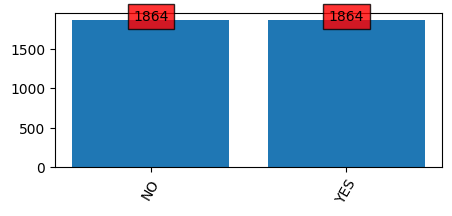

In [14]:
plot_histogram(r)

# Dataset

In [15]:
class RelationExtractionBinaryDataset(Dataset):
  def __init__(self, 
                 data,
                 tokenizer, w_vocab = None):
    self.data = data
    self.max_len = 128
    self.tokenizer = tokenizer
    self.single_sentences = self.rewrite_sentences()
    self.rel2idx = self.build_dictionary_relations()
    self.ent2idx = self.build_dictionary_entities()
    if w_vocab == None:
      self.w_vocab = self.build_vocab_words()
    else:
      self.w_vocab = w_vocab

  def select_only_entities_in_relations(self, elem, new_d, d):
    for m in re.finditer(elem, new_d['sentence']):
      start_id, end_id = m.span()
      token_start_id = new_d['sentence'][:start_id].count(" ")
      token_end_id = new_d['sentence'][:end_id].count(" ")
      for i in range(token_start_id, token_end_id+1):
        new_d['entities'][i] = d['entities'][i]
    return new_d

  def build_vocab_words(self):

    w_dict = {}
    counter = Counter()
    for elem in self.single_sentences:
      for w in elem["features"]:
        counter[w]+=1
    w_dict.update({'<pad>': 0})
    w_dict.update({'<unk>': 1})
    for index, (key,value) in enumerate(counter.most_common()):
      w_dict.update({key: index+2})
    
    return w_dict

  def rewrite_sentences(self):
    # riscrivo il dizionario dove ho una relazione (una tupla) per frase 
    new_data = []
    for d in self.data:
      if len(d['relations'])>0:
        for r in d['relations']:
          subj = r[0]
          obj = r[1]
          new_d = d.copy()
          new_d['relations'] = r
          new_d['NER'] = d['entities']
          new_d['entities'] = ['O' for _ in d['entities']]  # reset entities to "O" tags
          new_d = self.select_only_entities_in_relations(subj, new_d, d)
          new_d = self.select_only_entities_in_relations(obj, new_d, d)
          new_data.append(new_d)
      else:
        new_d = d.copy()
        new_d['relations'] = ()
        new_d['NER'] = d['entities']
        new_data.append(new_d)
    return new_data

  def build_dictionary_entities(self):
    # creazione del dizionario entità -> indice
    ent2idx = {"<pad>": 0,  'O': 1}
    for data_point in self.single_sentences:
      entities = data_point['NER']
      for e in entities:
        if e != "O":
          e = e.split("-")[1]
        if e not in ent2idx.keys():
            ent2idx[e] = len(ent2idx)
    return ent2idx

  def encode_words(self, sentence, offset, vocab):
    data = []
    for elem, (start, end) in  zip(sentence,offset):
      if elem in vocab.keys():

        data.append(vocab[elem])
      else:
        data.append(vocab["<unk>"])
      data+=[0]*(end-start-1)
    return [0] + data + [0]
 

  def build_dictionary_relations(self):
    rel2idx = {"no": 0, "yes": 1}
    return rel2idx

  def __len__(self):
      return len(self.single_sentences)
  
  def __getitem__(self, index):
      sentence = self.single_sentences[index]['sentence']
      entities = self.single_sentences[index]['entities']
      NER = self.single_sentences[index]['NER']
      features = self.single_sentences[index]['features']
      tuple_relation = self.single_sentences[index]['relations']

      curr_offset = 1
      word_offset = []
      sub_word_idx = []
      for featu in features:
        word_idx = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(featu))
        sub_word_idx += word_idx
        word_offset.append((curr_offset, curr_offset+len(word_idx)))
        curr_offset += len(word_idx)
      sub_word_idx = self.tokenizer.build_inputs_with_special_tokens(sub_word_idx)

      pretrained_words = self.encode_words(features, word_offset, self.w_vocab)

      attention_mask = [1]*len(sub_word_idx)
      entites_encoded = []
      NER_encoded = []  # CODICE DUPLICATO PER IL NER
      for i, (ner_e, e, (start, end)) in enumerate(zip(NER, entities, word_offset)):
        if e != "O" and e.split("-")[1] in self.ent2idx.keys():
          tag = e.split("-")[1]
          entites_encoded.append(self.ent2idx[tag])
          entites_encoded+=[self.ent2idx[tag]]*(end-start-1)
        elif e== "O":
          entites_encoded.append(self.ent2idx[e])
          entites_encoded+=[self.ent2idx[e]]*(end-start-1)

        # CODICE DUPLICATO PER IL NER
        if ner_e != "O" and ner_e.split("-")[1] in self.ent2idx.keys():
          tag = ner_e.split("-")[1]
          NER_encoded.append(self.ent2idx[tag])
          NER_encoded+=[self.ent2idx[tag]]*(end-start-1)
        elif ner_e== "O":
          NER_encoded.append(self.ent2idx[ner_e])
          NER_encoded+=[self.ent2idx[ner_e]]*(end-start-1)

      entites_encoded = [self.ent2idx['<pad>']]+entites_encoded+[self.ent2idx['<pad>']]

      # CODICE DUPLICATO PER IL NER
      NER_encoded = [self.ent2idx['<pad>']]+NER_encoded+[self.ent2idx['<pad>']]

      if len(tuple_relation) == 0:
        labels = self.rel2idx["no"]
      else:
        labels = self.rel2idx["yes"]
      assert(len(attention_mask)==len(sub_word_idx))

      item = {
         "input_ids": torch.tensor(sub_word_idx),
         "attention_mask": torch.tensor(attention_mask),
         "entites_encoded": torch.tensor(entites_encoded),
         "NER_encoded": torch.tensor(NER_encoded),
         "pretrained_words": torch.tensor(pretrained_words),
         "labels": torch.tensor([labels])
      }

      return item

## Init dataset

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = RelationExtractionBinaryDataset(train_set, tokenizer)
word_vocab = train_dataset.w_vocab
dict_labels = train_dataset.rel2idx
dict_entities = train_dataset.ent2idx
valid_dataset = RelationExtractionBinaryDataset(val_set, tokenizer, word_vocab)
test_dataset = RelationExtractionBinaryDataset(test_set, tokenizer, word_vocab)

## Esempio elemento dataset

In [17]:
for i,elem in enumerate(valid_dataset):
  sentence_encoded = elem["input_ids"]
  attention_mask = elem["attention_mask"]
  entitites_encoded = elem["entites_encoded"]
  NER_encoded = elem["NER_encoded"]
  pretrained_words = elem["pretrained_words"]
  labels = elem["labels"]
  entities_invertito = {valore: chiave for chiave, valore in dict_entities.items()}
  lab_invertito = {valore: chiave for chiave, valore in dict_labels.items()}
  print(f"idx: {i},\nfrase: {tokenizer.decode(sentence_encoded)}, \
        \ntokens: {tokenizer.convert_ids_to_tokens(sentence_encoded)}\
        \nencoded tokens: {sentence_encoded}, shape: {sentence_encoded.shape} \
        \nattention mask: {attention_mask}, shape: {attention_mask.shape} \
        \npretrained_words: {pretrained_words}, shape: {pretrained_words.shape} \
        \nentities: {[entities_invertito[e.item()] for e in entitites_encoded]}\
        \nencoded entities: {entitites_encoded}, shape: {entitites_encoded.shape}\
        \nencoded NER: {NER_encoded}, shape: {NER_encoded.shape}\
        \nlabels: {lab_invertito[labels.item()]}\
        \nencoded labels: {labels}, shape:{labels.shape}")
  break

idx: 0,
frase: [CLS] this oven has a flat belt conveyor with three zones and complete controls. [SEP],         
tokens: ['[CLS]', 'this', 'oven', 'has', 'a', 'flat', 'belt', 'convey', '##or', 'with', 'three', 'zones', 'and', 'complete', 'controls', '.', '[SEP]']        
encoded tokens: tensor([  101,  2023, 17428,  2038,  1037,  4257,  5583, 16636,  2953,  2007,
         2093, 10019,  1998,  3143,  7711,  1012,   102]), shape: torch.Size([17])         
attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), shape: torch.Size([17])         
pretrained_words: tensor([   0,   32, 2640,   19,    4, 2132,    1,    1,    0,   11,  111,    1,
           5, 1887,    1,    0,    0]), shape: torch.Size([17])         
entities: ['<pad>', 'O', 'Entity', 'O', 'O', 'O', 'O', 'Collection', 'Collection', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<pad>']        
encoded entities: tensor([0, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0]), shape: torch.Size([17])        
encoded NER: ten

# Dataloader

In [18]:
def padding_function(elems):
  max_len = 128
  input_ids = [elem["input_ids"] for elem in elems]
  attention_mask = [elem["attention_mask"] for elem in elems]
  pretrained_words = [elem["pretrained_words"] for elem in elems]
  entities = [elem["entites_encoded"] for elem in elems]
  NER = [elem["NER_encoded"] for elem in elems]
  labels = [elem["labels"] for elem in elems]

  input_ids[0] = nn.ConstantPad1d((0, max_len - input_ids[0].shape[0]), 0)(input_ids[0])
  attention_mask[0] = nn.ConstantPad1d((0, max_len - attention_mask[0].shape[0]), 0)(attention_mask[0])
  pretrained_words[0] = nn.ConstantPad1d((0, max_len - pretrained_words[0].shape[0]), 0)(pretrained_words[0])
  entities[0] = nn.ConstantPad1d((0, max_len - entities[0].shape[0]), 0)(entities[0])
  NER[0] = nn.ConstantPad1d((0, max_len - NER[0].shape[0]), 0)(NER[0])

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value = 0)
  attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value = 0)
  pretrained_words = pad_sequence(pretrained_words, batch_first=True, padding_value = 0)
  entities = pad_sequence(entities, batch_first=True, padding_value = 0)
  NER = pad_sequence(NER, batch_first=True, padding_value = 0)
  labels = torch.stack(labels, dim=0)

  item = {
      "input_ids" : input_ids,
      "attention_mask": attention_mask,
      "entities": entities,
      "NER": NER,
      "pretrained_words": pretrained_words,
      "labels": labels
  }
  assert(input_ids.shape[1]==max_len)
  return item

## Init dataloader

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=padding_function, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, collate_fn=padding_function)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=padding_function)

## Esempio elemento dataloader

In [20]:
for i,elem in enumerate(train_dataloader):
  sentence_encoded = elem["input_ids"]
  attention_mask = elem["attention_mask"]
  entitites_encoded = elem["entities"]
  NER_encoded = elem["NER"]
  pretrained_words = elem["pretrained_words"]
  labels = elem["labels"]
  entities_invertito = {valore: chiave for chiave, valore in dict_entities.items()}
  lab_invertito = {valore: chiave for chiave, valore in dict_labels.items()}
  print(f"idx: {i},\nfrase: {sentence_encoded}, shape: {sentence_encoded.shape}, \
        \nattention mask: {attention_mask}, shape: {attention_mask.shape}, \
        \nentities: {entitites_encoded}, shape: {entitites_encoded.shape}\
        \nNER: {NER_encoded}, shape: {NER_encoded.shape}\
        \npretrained_words: {pretrained_words}, shape: {pretrained_words.shape}, \
        \nlabels: {labels}, shape: {labels.shape}")
  break

idx: 0,
frase: tensor([[ 101, 1999, 3522,  ...,    0,    0,    0],
        [ 101, 1996, 2433,  ...,    0,    0,    0],
        [ 101, 1998, 2009,  ...,    0,    0,    0],
        ...,
        [ 101, 2073, 1037,  ...,    0,    0,    0],
        [ 101, 1049, 2546,  ...,    0,    0,    0],
        [ 101, 2009, 3849,  ...,    0,    0,    0]]), shape: torch.Size([8, 128]),         
attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), shape: torch.Size([8, 128]),         
pretrained_words: tensor([[    0,    33,   222,  ...,     0,     0,     0],
        [    0,     6,   418,  ...,     0,     0,     0],
        [    0,   285,    31,  ...,     0,     0,     0],
        ...,
        [    0, 10407,     4,  ...,     0,     0,     0],
        [    0, 11003,     0,  ...,     0,     0,     0],
        [    0,    73, 110

# Pretrained

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-05-19 14:49:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-19 14:49:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-19 14:49:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [22]:
class PreTrainedEmbedding():
  def __init__(self,
               path:str, 
               dim:int, 
               vocab:dict):
    
    self.path = path
    self.dim = dim
    self.vocab = vocab

    self.dictionary_emb = self.build_dictionary()
    self.weights = self.embedding_weights() 
  
  def build_dictionary(self):
    
    dictionary = {}
    with open(self.path) as file_:
      for line in file_.readlines():
        data = []
        elem = line.strip().split()
        word = elem[0]
        for i in range (self.dim):
          data.append(float(elem[i+1]))
        dictionary[word]=data
    return dictionary

  def embedding_weights(self):
    
    embeddings_weights = torch.zeros([len(self.vocab),self.dim])
    random = torch.rand(1,self.dim)[0]

    for elem in self.vocab:
      if elem not in self.dictionary_emb:
        embeddings_weights[self.vocab[elem]] = random
      else:
        embeddings_weights[self.vocab[elem]] = torch.tensor(self.dictionary_emb[elem])
   
    return embeddings_weights

In [23]:
pre_embeddings = PreTrainedEmbedding("./glove.6B.300d.txt", 300, word_vocab)

# Modello

In [24]:
class RelationExtractionBinaryModel(Module):
  def __init__(self, hparams):
    super(RelationExtractionBinaryModel, self).__init__()
    self.bert = BertModel.from_pretrained(hparams.transformer_model)
    self.pretrained_embedding = nn.Embedding(hparams.w_vocab_size, hparams.embedding_dim_pretrained)
    self.NER_embedding = nn.Embedding(hparams.NER_vocab_size, hparams.embedding_dim_NER)
    self.lstm = LSTM( hparams.embedding_dim_words + 
                      hparams.embedding_dim_NER*2 +
                      hparams.embedding_dim_pretrained,
                      hparams.hidden_dim, 
                      bidirectional = hparams.bidirectional,
                      num_layers = hparams.num_layers, 
                      batch_first = True,
                      dropout = hparams.dropout if hparams.num_layers > 1 else 0
                     )
    self.pretrained_embedding.weight.data.copy_(hparams.pretrained_embeddings.weights)
    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
    self.dropout = Dropout(hparams.dropout)
    self.classifier = Linear(lstm_output_dim*hparams.max_len, hparams.num_classes)

  def forward(self, input_ids, mask, entities_e, NER_e, pretrained):
    embeddings = self.bert(input_ids, attention_mask=mask)[0]
    embeddings_pretrained  =self.pretrained_embedding(pretrained)
    embeddings_entities = self.NER_embedding(entities_e)
    embeddings_NER = self.NER_embedding(NER_e)
    embeddings = torch.cat((embeddings, embeddings_entities, embeddings_NER, embeddings_pretrained), dim=2) # batch, n_seq, emb_bert + emb_NER*2
    o, (h, c) = self.lstm(embeddings) # (batch, n_seq, 512)
    o = o.flatten(start_dim=1) # (batch, n_seq * 512)
    output = self.classifier(o)  
    return output

## Hparameters

In [25]:
class HParams():
    def __init__(self,l_vocab, ner_vocab, bert_model, w_vocab, pretrained_embeddings):
      self.transformer_model = bert_model
      self.NER_vocab_size = len(ner_vocab)
      self.fine_tune = False
      self.pretrained_embeddings = pretrained_embeddings
      self.w_vocab_size = len(w_vocab)
      self.embedding_dim_pretrained = 300
      self.embedding_dim_words = 768
      self.embedding_dim_NER = 100
      self.hidden_dim = 256
      self.max_len = 128
      self.num_classes = 1
      self.bidirectional = True
      self.num_layers = 2
      self.dropout = 0.3

## Init Modello

In [26]:
params = HParams(dict_labels, dict_entities, 'bert-base-uncased', word_vocab, pre_embeddings)
model = RelationExtractionBinaryModel(params).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train, Validation, Predict

In [30]:
class Trainer():

  def __init__(
      self,
      model: Module,
      loss_function,
      optimizer,
      tokenizer,
      label_vocab,
      patience, 
      save_path):
    
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.tokenizer = tokenizer
    self.label_vocab = label_vocab 
    self.patience = patience
    self.best_valid_f1 = 0.0
    self.best_loss = 0.0
    self.early_stop_counter = 0
    self.save_path = save_path
  
  def train(self, train_dataset, valid_dataset, epochs:int=1):
    train_loss = 0.0
    for epoch in range(epochs):
      epoch_loss = 0.0
      self.model.train()
      train_iterator = tqdm(train_dataset)
      f1_scores = list()
      accuracies = list()
      y_true, y_pred = [], []
      for step, sample in enumerate(train_iterator):

        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        pretrained_embeddings = sample['pretrained_words'].to(device)
        entitites = sample['entities'].to(device)
        NER = sample['NER'].to(device)
        labels = sample['labels'].to(device) # (batch, 1)

        self.optimizer.zero_grad()

        predictions = self.model(input_ids, attention_mask, entitites, NER, pretrained_embeddings)
        sample_loss = self.loss_function(predictions, labels.float())

        sample_loss.backward()

        self.optimizer.step()

        epoch_loss += sample_loss.item()
        avg_loss = epoch_loss / (step + 1)

        preds = torch.round(torch.sigmoid(predictions))
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())

        f1 = f1_score(labels.cpu().numpy(), preds.detach().cpu().numpy(), average="binary", zero_division=0)
        acc = accuracy_score(labels.cpu().numpy(), preds.detach().cpu().numpy())

        train_iterator.set_postfix(
          loss=avg_loss,
          epoch=epoch,
          f1_score = f1,
          accuracy = acc,
          step=(step + 1)
        )
        f1_scores.append(f1)
        accuracies.append(acc)

      training_metrics = {}
      training_metrics['loss'] = epoch_loss / len(train_dataset) if epoch_loss > 0 else 0.0 
      training_metrics['f1'] = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
      training_metrics['accuracy'] = sum(accuracies) / len(accuracies) if accuracies else 0.0
      validation_metrics = self.evaluate(valid_dataset, epoch)

      # Early stopping check
      valid_f1 = validation_metrics['f1']
      valid_loss = validation_metrics['loss']
      if valid_f1 > self.best_valid_f1 or valid_loss < self.best_loss:
          self.best_valid_f1 = valid_f1
          self.early_stop_counter = 0
          if self.save_path is not None:
              torch.save(self.model.state_dict(), self.save_path)
      else:
          self.early_stop_counter += 1
          if self.early_stop_counter >= self.patience:
              print("Early stopping triggered. No improvement in validation F1 score.")
              break

      keys = set()
      keys |= set(training_metrics.keys())
      keys |= set(validation_metrics.keys())

      table = []

      for key in keys:
          table.append((key, training_metrics.get(key, float('Nan')), validation_metrics.get(key, float('Nan'))))

      print(tabulate(table, headers=('metric', 'train', 'dev')) + '\n')

  def evaluate(self, valid_dataset, epoch):
    valid_loss = 0.0
    self.model.eval()
    f1_scores = list()
    accuracies = list()
    y_true, y_pred = [], []
    with torch.no_grad():
      valid_iterator = tqdm(valid_dataset)
      for step,  sample in enumerate(valid_iterator):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        pretrained_embeddings = sample['pretrained_words'].to(device)
        entitites = sample['entities'].to(device)
        NER = sample['NER'].to(device)
        labels = sample['labels'].to(device)
        predictions = self.model(input_ids, attention_mask, entitites, NER, pretrained_embeddings)
        sample_loss = self.loss_function(predictions, labels.float())
        valid_loss += sample_loss.tolist()
        avg_loss = valid_loss / (step + 1)

        preds = torch.round(torch.sigmoid(predictions))
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        
        f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average="binary", zero_division=0)
        acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        valid_iterator.set_postfix(
          loss=avg_loss,
          epoch=epoch,
          f1_score = f1,
          accuracy = acc,
          step=(step + 1)
        )

        f1_scores.append(f1)
        accuracies.append(acc)

    metrics = {}
    metrics['loss'] = valid_loss / len(valid_dataset) if valid_loss > 0 else 0.0 
    metrics['f1'] = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
    metrics['accuracy'] = sum(accuracies) / len(accuracies) if accuracies else 0.0

    return metrics

  def predict(self, test_dataset):
    self.model.eval()
    f1_scores = list()
    accuracies = list()
    y_true, y_pred = [], []
    with torch.no_grad():
      test_iterator = tqdm(test_dataset)
      for step,  sample in enumerate(test_iterator):
        input_ids = sample['input_ids'].to(device)
        attention_mask = sample['attention_mask'].to(device)
        pretrained_embeddings = sample['pretrained_words'].to(device)
        entitites = sample['entities'].to(device)
        NER = sample['NER'].to(device)
        labels = sample['labels'].to(device)
        predictions = self.model(input_ids, attention_mask, entitites, NER, pretrained_embeddings)

        preds = torch.round(torch.sigmoid(predictions))
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        
        f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average="binary", zero_division=0)
        acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

        test_iterator.set_postfix(
          f1_score = f1,
          accuracy = acc,
          step=(step + 1)
        )

        f1_scores.append(f1)
        accuracies.append(acc)
    return y_pred, y_true,  sum(f1_scores) / len(f1_scores), sum(accuracies) / len(accuracies)

## Init Trainer

In [31]:
trainer = Trainer(
    model = model,
    loss_function = nn.BCEWithLogitsLoss(),
    optimizer = optim.Adam(model.parameters(), lr=2e-5),
    tokenizer = tokenizer,
    label_vocab= dict_labels,
    patience = 5,
    save_path = "model_prova.pth"
)

### Training

In [32]:
trainer.train(train_dataloader, valid_dataloader, 50)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

metric       train       dev
--------  --------  --------
loss      0.419674  0.589351
accuracy  0.817101  0.68838
f1        0.78843   0.645991



  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

metric       train       dev
--------  --------  --------
loss      0.167679  0.957919
accuracy  0.93865   0.670775
f1        0.920458  0.676831



  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

metric        train       dev
--------  ---------  --------
loss      0.0509336  1.41731
accuracy  0.984663   0.669014
f1        0.982992   0.662493



  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

metric        train       dev
--------  ---------  --------
loss      0.0317497  1.37545
accuracy  0.988497   0.691901
f1        0.98456    0.660309



  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

metric        train       dev
--------  ---------  --------
loss      0.0184571  1.78624
accuracy  0.994248   0.684859
f1        0.98792    0.670906



  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

metric        train       dev
--------  ---------  --------
loss      0.0188029  1.49656
accuracy  0.994248   0.700704
f1        0.994645   0.660111



  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Early stopping triggered. No improvement in validation F1 score.


### Predict

In [33]:
predictions, true_labels, accuracy, f1 = trainer.predict(test_dataloader)

  0%|          | 0/70 [00:00<?, ?it/s]

In [34]:
print(f"Before Accuracy test: {accuracy}, Accuracy f1: {f1}")

Before Accuracy test: 0.6853172224600793, Accuracy f1: 0.6744897959183673


# Confusion metrics

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

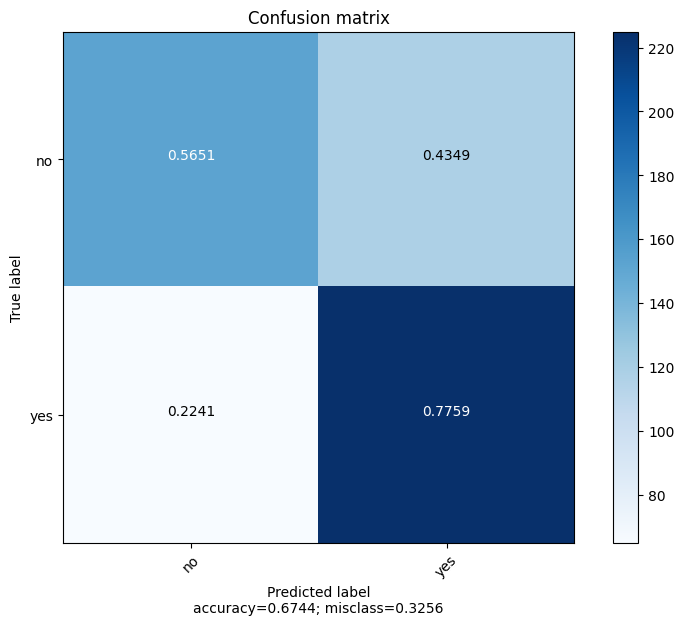

In [36]:
cm = confusion_matrix(true_labels, predictions)
plot_confusion_matrix(cm, ["no", "yes"])